In [3]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data = pd.read_parquet("2-renamed_data.parquet", index = 0)

# ProfileReport(data).to_file("cars_report_historical.html")

car_dict = pd.read_csv('2-data.dict.cars.csv')

To Pickup tomorrow 7/12:
1. set the datasets to be picked up here, created from 2
2. join the datasets and do advanced visualisation 
3. hopefully model

In [25]:
def collapse_wide_cols(data, columns, label):
    
    
    """Function checks that all one-hot encoded columns have a value, and labels it as a new variable.
        
    Parameters
    ----------
    df : pandas dataframe holding the columns wishing to shorten.
    columns : list of str
        List of columns labels to read from.
    label : str,
        Label for the collapsed new variable
        
    Returns
    -------
    If successful: a dataframe which has dropped one hot encoded variables and prints success
    if not successful: prints an error and the number of values that are missing a one hot encoded variable for review
    
    """
    
    subdf = data[columns].copy(deep=True)
        
    sum_value = subdf.values.sum() # adds all of the values in the column, there should only be a single 1 value for each variable category.
    
    if sum_value == len(data):    # if this number is equal to the length of the original dataframe it is good and merges
        def collapse(row):
            return(row.index[row.apply(lambda x: x==1)][0])
        
        subdf[label] = subdf.apply(lambda row: collapse(row), axis=1)
        
        subdf.drop(columns = columns, inplace = True)
        
        data = pd.concat([data, subdf.reset_index(drop=True)], axis = 1)
        print('correct data - merging')
        
        return data
    
    else: # if this number is not equal then it finds the bad rows and prints them out.
        bad_rows = data.loc[(data[columns].sum(axis=1) != 1), ]
        print('rows with missing values are...')
        display(bad_rows)
            

## Drivetrain feature

Need to collapse the drivetrain into long format

In [26]:
columns = car_dict.loc[car_dict.eval("category == 'drivetrain'"), "variable"]  #extract all of the drivetrain types from the data dictionary & keep the variable only that becomes columns
data_drivetrain = collapse_wide_cols(data, columns, label = "drivetrain")

rows with missing values are...


,vehicle_name,sedan,sports_car,suv,wagon,minivan,pickup,awd,rwd,retail_price,dealer_cost,engine_size_(l),cyl,hp,city_mpg,hwy_mpg,weight,wheel_base,len,width
0,Acura 3.5 RL 4dr,1,0,0,0,0,0,0,0,43755,39014,3.5,6,225,18.0,24.0,3880.0,115.0,197.0,72.0
1,Acura 3.5 RL w/Navigation 4dr,1,0,0,0,0,0,0,0,46100,41100,3.5,6,225,18.0,24.0,3893.0,115.0,197.0,72.0
4,Acura RSX Type S 2dr,1,0,0,0,0,0,0,0,23820,21761,2.0,4,200,24.0,31.0,2778.0,101.0,172.0,68.0
5,Acura TL 4dr,1,0,0,0,0,0,0,0,33195,30299,3.2,6,270,20.0,28.0,3575.0,108.0,186.0,72.0
6,Acura TSX 4dr,1,0,0,0,0,0,0,0,26990,24647,2.4,4,200,22.0,29.0,3230.0,105.0,183.0,69.0
7,Audi A4 1.8T 4dr,1,0,0,0,0,0,0,0,25940,23508,1.8,4,170,22.0,31.0,3252.0,104.0,179.0,70.0
8,Audi A4 3.0 4dr,1,0,0,0,0,0,0,0,31840,28846,3.0,6,220,20.0,28.0,3462.0,104.0,179.0,70.0
9,Audi A4 3.0 convertible 2dr,1,0,0,0,0,0,0,0,42490,38325,3.0,6,220,20.0,27.0,3814.0,105.0,180.0,70.0
13,Audi A41.8T convertible 2dr,1,0,0,0,0,0,0,0,35940,32506,1.8,4,170,23.0,30.0,3638.0,105.0,180.0,70.0
15,Audi A6 3.0 4dr,1,0,0,0,0,0,0,0,36640,33129,3.0,6,220,20.0,27.0,3561.0,109.0,192.0,71.0


THere are 226 missing, this is a very bad data failure, something is wrong here. I think it is missing fwd.

In [27]:
drivetrain = data[(data['awd'] == 0) & (data['rwd'] == 0)]
print(str(len(drivetrain)) + ' vehicles with no drivetrain info')

226 vehicles with no drivetrain info


Correct, there are no drivetrain values in these cars. Need to build a new fwd feature and update the data dictionary to include it.

In [35]:
car_dict = pd.read_csv('2-data.dict.cars.added.fwd.csv')

In [36]:
def fwdvalue(data):
    if data['awd'] == 0 & data['rwd'] == 0:
        val = 1
    else:
        val = 0
    return val

In [37]:
data['fwd'] = data.apply(fwdvalue, axis=1)
checker = data[['awd', 'rwd', 'fwd']]

In [38]:
columns = car_dict.loc[car_dict.eval("category == 'drivetrain'"), "variable"]  #extract all of the drivetrain types from the data dictionary & keep the variable only that becomes columns
data_drivetrain = collapse_wide_cols(data, columns, label = "drivetrain")

rows with missing values are...


,vehicle_name,sedan,sports_car,suv,wagon,minivan,pickup,awd,rwd,retail_price,...,engine_size_(l),cyl,hp,city_mpg,hwy_mpg,weight,wheel_base,len,width,fwd
3,Acura NSX coupe 2dr manual S,0,1,0,0,0,0,0,1,89765,...,3.2,6,290,17.0,24.0,3153.0,100.0,174.0,71.0,1
26,BMW 325Ci 2dr,1,0,0,0,0,0,0,1,30795,...,2.5,6,184,20.0,29.0,3197.0,107.0,177.0,69.0,1
27,BMW 325Ci convertible 2dr,1,0,0,0,0,0,0,1,37995,...,2.5,6,184,19.0,27.0,3560.0,107.0,177.0,69.0,1
28,BMW 325i 4dr,1,0,0,0,0,0,0,1,28495,...,2.5,6,184,20.0,29.0,3219.0,107.0,176.0,69.0,1
31,BMW 330Ci 2dr,1,0,0,0,0,0,0,1,36995,...,3.0,6,225,20.0,30.0,3285.0,107.0,176.0,69.0,1
32,BMW 330Ci convertible 2dr,1,0,0,0,0,0,0,1,44295,...,3.0,6,225,19.0,28.0,3616.0,107.0,177.0,69.0,1
33,BMW 330i 4dr,1,0,0,0,0,0,0,1,35495,...,3.0,6,225,20.0,30.0,3285.0,107.0,176.0,69.0,1
35,BMW 525i 4dr,1,0,0,0,0,0,0,1,39995,...,2.5,6,184,19.0,28.0,3428.0,114.0,191.0,73.0,1
36,BMW 530i 4dr,1,0,0,0,0,0,0,1,44995,...,3.0,6,225,20.0,30.0,3472.0,114.0,191.0,73.0,1
37,BMW 545iA 4dr,1,0,0,0,0,0,0,1,54995,...,4.4,8,325,18.0,26.0,3814.0,114.0,191.0,73.0,1


<AxesSubplot:xlabel='drivetrain', ylabel='counts'>

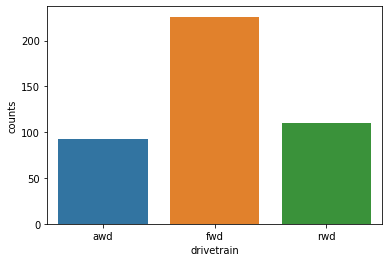

In [22]:
freq = data_drivetrain.groupby(['drivetrain']).size().reset_index(name='counts')
sns.barplot(x="drivetrain", y="counts", data=freq)

## Car Type

In [23]:
columns = car_dict.loc[car_dict.eval("category == 'car_type'"), "variable"]  #extract all of the drivetrain types from the data dictionary & keep the variable only that becomes columns
data_cartype = collapse_wide_cols(data, columns, label = "Car Type")
data_cartype

rows with missing values are...


,vehicle_name,sedan,sports_car,suv,wagon,minivan,pickup,awd,rwd,retail_price,...,engine_size_(l),cyl,hp,city_mpg,hwy_mpg,weight,wheel_base,len,width,fwd
22,Audi S4 Quattro 4dr,0,0,0,0,0,0,1,0,48040,...,4.2,8,340,14.0,20.0,3825.0,104.0,179.0,70.0,0
